In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from scipy.special import erf

az.rcParams["plot.max_subplots"] = 80

First, load the output of our inference as an arviz InferenceData object:

In [2]:
data = az.from_netcdf("ar_z_sfr.cdf")
#data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_tauMax_2_relaxed.cdf")
az.summary(data,["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"])

arviz - WARNING - Shape validation failed: input_shape: (1, 750), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_z_std,0.728,0.470,0.000,1.534,0.028,0.020,277.0,361.0,NaN
ar_z_tau,0.848,0.371,0.201,1.409,0.011,0.008,1084.0,385.0,NaN
logR20,-0.564,0.337,-1.102,0.262,0.017,0.014,441.0,315.0,NaN
alpha,-3.807,0.302,-4.408,-3.289,0.010,0.007,839.0,501.0,NaN
mMin,9.188,0.850,7.664,11.064,0.030,0.021,814.0,510.0,NaN
log_dmMin,-0.401,0.358,-0.995,0.180,0.013,0.011,700.0,388.0,NaN
mu_m1,33.810,1.829,30.436,36.691,0.101,0.072,466.0,314.0,NaN
sig_m1,4.016,1.749,2.007,7.338,0.090,0.068,557.0,320.0,NaN
log_f_peak,-2.664,0.234,-2.997,-2.250,0.008,0.006,682.0,325.0,NaN
mMax,78.736,13.116,56.007,99.858,0.409,0.297,941.0,340.0,NaN


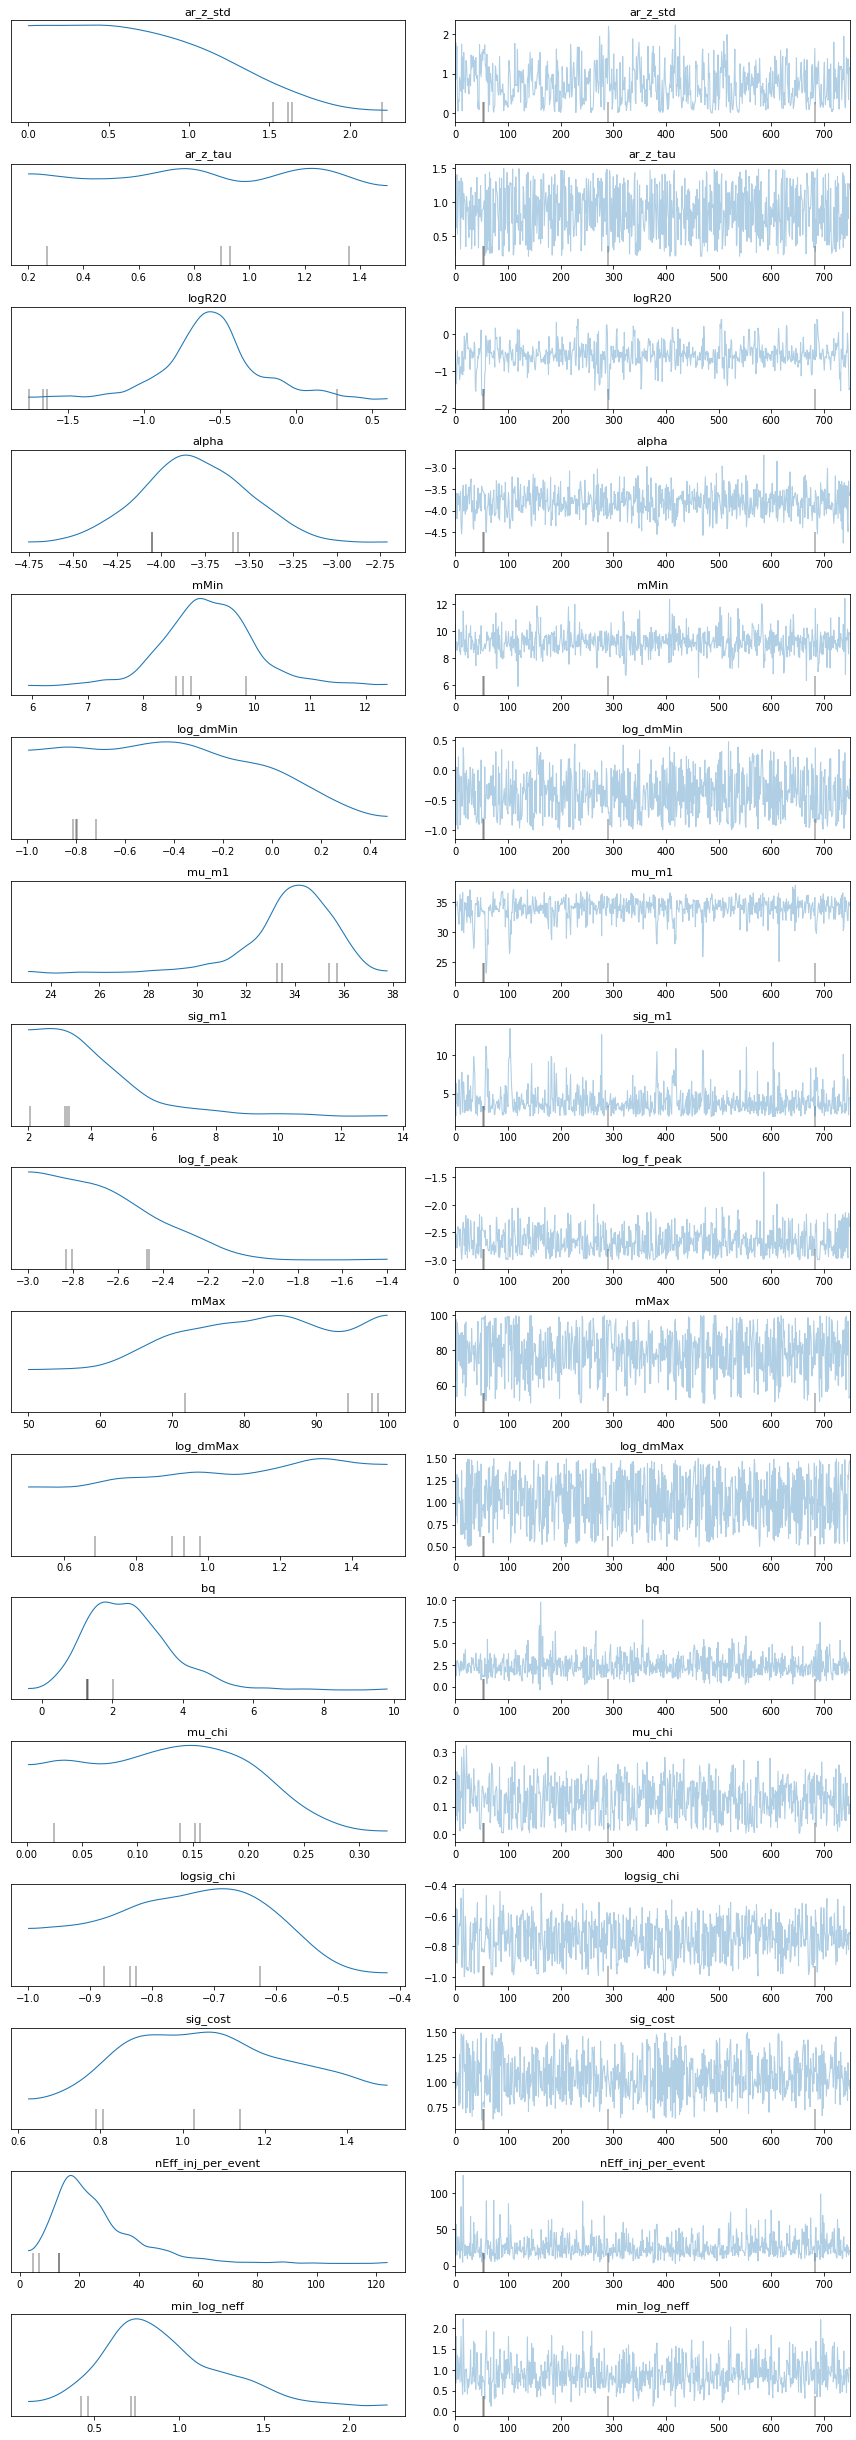

In [3]:
az.plot_trace(data,
              ["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"], compact=True)
plt.tight_layout()
plt.show()

In [4]:
z_data = np.load('ar_z_data_sfr.npy',allow_pickle=True)[()]
#z_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_data_tauMax_2_relaxed.npy',allow_pickle=True)[()]
z_values = z_data['z_allSamples']
samps = data.posterior.stack(draws=("chain", "draw"))

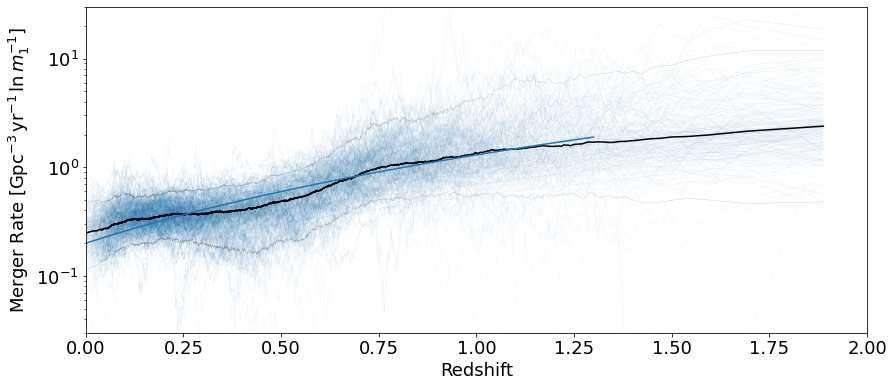

In [5]:
reduced_zs = z_values[::50]
reduced_f_zs = samps['f_zs'][::50]

R_zs = np.zeros((reduced_zs.size,reduced_f_zs.shape[1]))
for i in range(reduced_f_zs.shape[1]):
    R_zs[:,i] = samps.R20[i]*reduced_f_zs[:,i]*(1.+reduced_zs)**2

fig,ax = plt.subplots(figsize=(14,6))
for i in np.random.choice(range(reduced_f_zs.shape[1]),500):
    ax.plot(reduced_zs,R_zs[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

zs = np.linspace(0,1.3,300)
ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,2)
ax.set_ylim(3e-2,30)
ax.set_yscale('log')

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

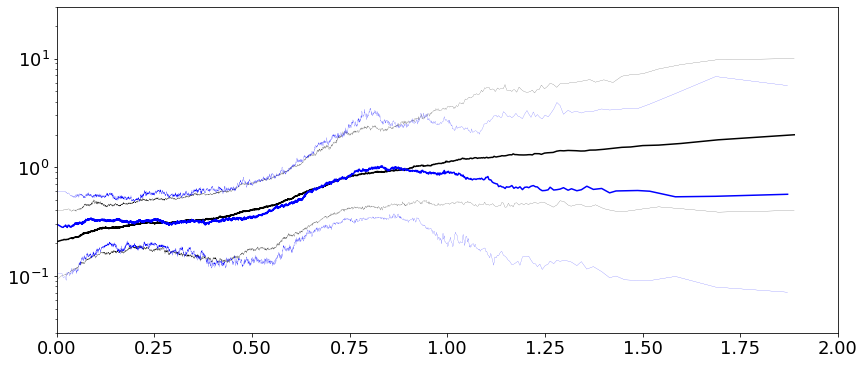

In [6]:
data_alt = az.from_netcdf("ar_z.cdf")
samps_alt = data_alt.posterior.stack(draws=("chain", "draw"))
z_data_alt = np.load('ar_z_data.npy',allow_pickle=True)[()]
z_values_alt = z_data_alt['z_allSamples']

reduced_zs_alt = z_values_alt[::50]
reduced_f_zs_alt = samps_alt['f_zs'][::50]

R_zs_alt = np.zeros((reduced_zs_alt.size,reduced_f_zs_alt.shape[1]))
for i in range(reduced_f_zs_alt.shape[1]):
    R_zs_alt[:,i] = samps_alt.R20[i]*reduced_f_zs_alt[:,i]
    
fig,ax = plt.subplots(figsize=(14,6))

ax.plot(reduced_zs,np.median(R_zs,axis=1)/(1.+0.2),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1)/(1.+0.2),color='black',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1)/(1.+0.2),color='black',lw=0.15)

ax.plot(reduced_zs_alt,np.median(R_zs_alt,axis=1),color='blue')
ax.plot(reduced_zs_alt,np.quantile(R_zs_alt,0.05,axis=1),color='blue',lw=0.15)
ax.plot(reduced_zs_alt,np.quantile(R_zs_alt,0.95,axis=1),color='blue',lw=0.15)

#zs = np.linspace(0,1.3,300)
#ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,2)
ax.set_ylim(3e-2,30)
ax.set_yscale('log')

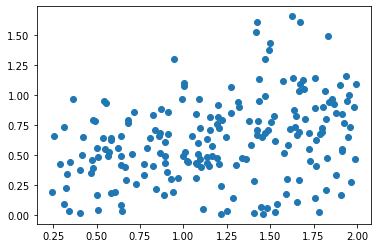

In [9]:
tau = samps['ar_z_tau']
std = samps['ar_z_std']
fig,ax = plt.subplots()
ax.scatter(tau,std)

In [ ]:
reduced_zs = z_values[::50]
reduced_f_zs = samps['f_zs'][::50,tau<1]

R_zs = np.zeros((reduced_zs.size,reduced_f_zs.shape[1]))
for i in range(reduced_f_zs.shape[1]):
    R_zs[:,i] = samps.R20[i]*reduced_f_zs[:,i]

fig,ax = plt.subplots(figsize=(14,6))
for i in np.random.choice(range(reduced_f_zs.shape[1]),500):
    ax.plot(reduced_zs,R_zs[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

zs = np.linspace(0,1.3,300)
ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.25)
ax.set_ylim(3e-2,10)
#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

In [7]:
ratios = np.zeros(reduced_f_zs.shape[1])
for i in range(reduced_f_zs.shape[1]):
    
    R02 = np.interp(0.2,reduced_zs,reduced_f_zs[:,i])
    R08 = np.interp(0.8,reduced_zs,reduced_f_zs[:,i])
    ratios[i] = R08/R02

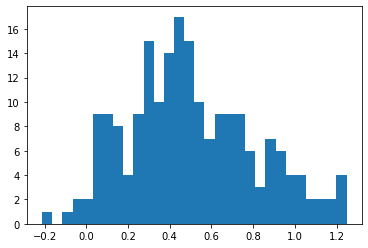

In [8]:
fig,ax = plt.subplots()
ax.hist(np.log10(ratios),bins=30)
plt.show()

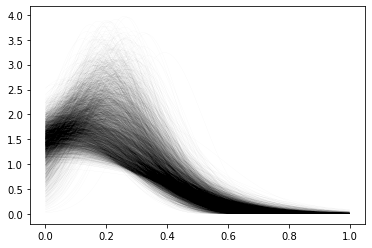

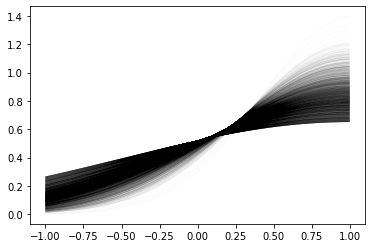

In [9]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

fig,ax = plt.subplots()
grid = np.linspace(0,1,1000)
for i in range(samps.mu_chi.size):
    
    p_chi = gaussian(grid,samps.mu_chi.values[i],10.**samps.logsig_chi.values[i],-1,1)
    ax.plot(grid,p_chi,color='black',lw=0.1,alpha=0.1)
plt.show()

fig,ax = plt.subplots()
grid = np.linspace(-1,1,1000)
for i in range(samps.mu_chi.size):
    
    #p_cost = gaussian(grid,samps.mu_cost.values[i],samps.sig_cost.values[i],-1,1)
    p_cost = gaussian(grid,1.,samps.sig_cost.values[i],-1,1)

    ax.plot(grid,p_cost,color='black',lw=0.1,alpha=0.1)
plt.show()